## Loading data and model

In [45]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.functional import F
from torch.utils.data import DataLoader, Dataset

import wandb
from data_loader import (
    DATA_FEATURE_NAMES_LIST,
    concat_group_data,
    get_balanced_data,
    load_data,
    normalize_features,
)

USE_CONCAT_CTS = False
USE_CT = "Pvalb_Gaba"
if USE_CONCAT_CTS:
    CTS = [
        "L23_IT_CTX_Glut",
        "L6_CT_CTX_Glut",
        "L5_ET_CTX_Glut",
        "L6_IT_CTX_Glut",
        "Oligo_NN",
        "Pvalb_Gaba",
    ]  #
    CT = ",".join(CTS)
    X_balanced, y_balanced, gene_list = concat_group_data(CT)
else:
    CT = USE_CT
    data = load_data(ct=CT)
    X_balanced, y_balanced, gene_list = get_balanced_data(data)

import os

ML_OUTPUT_DIR = f"ml_output/{CT}"
os.makedirs(ML_OUTPUT_DIR, exist_ok=True)

assert len(y_balanced) == len(gene_list)

FEATURE_MODALITIES = DATA_FEATURE_NAMES_LIST

for k, v in X_balanced.items():
    print(k, len(v))

import os

# 68%
HIDDEN_DIM = 64
NUM_LAYERS = 2
NUM_HEADS = 4
TEMPERATURE = 1.0
DROPOUT = 0.15
LR = 3e-3
OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
NUM_EPOCHS = 20
BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 4
# NUM_HEADS = 8
# DROPOUT = 0.0
# LR = 0.03
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 20
# BATCH_SIZE = 32

# HIDDEN_DIM = 64
# NUM_LAYERS = 1
# NUM_HEADS = 1
# DROPOUT = 0.3
# LR = 1e-4
# OUTPUT_DIM = 3  # number of classes (-1, 0, 1)
# NUM_EPOCHS = 200
# BATCH_SIZE = 16


class MultiModalityTransformerModel(nn.Module):
    def __init__(
        self,
        modality_input_dims,
        hidden_dim,
        output_dim,
        num_layers=2,
        num_heads=1,
        dropout=0.1,
        temperature=1.0,
    ):
        super(MultiModalityTransformerModel, self).__init__()
        self.cls_embeddings = nn.ParameterDict(
            {
                modality: nn.Parameter(torch.randn(1, 1, hidden_dim))
                for modality in FEATURE_MODALITIES
            }
        )
        self.modality_embeddings = nn.ModuleDict(
            {
                modality: nn.Linear(modality_input_dims[modality], hidden_dim)
                for modality in FEATURE_MODALITIES
            }
        )

        # TODO: may need to use tanh in attention instead of softmax
        encoder_layers = nn.TransformerEncoderLayer(
            hidden_dim,
            num_heads,
            dim_feedforward=hidden_dim * 4,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.modality_transformers = nn.ModuleDict(
            {
                modality: nn.TransformerEncoder(encoder_layers, num_layers)
                for modality in FEATURE_MODALITIES
            }
        )

        # Add one dimension for the sequence length
        self.batch_norms = nn.ModuleDict(
            {
                modality: nn.BatchNorm1d(hidden_dim + 1)
                for modality in FEATURE_MODALITIES
            }
        )

        # Use self-attention mechanism to combine the outputs of the four heads
        self.temperature = temperature
        self.query = nn.Parameter(torch.randn(1, hidden_dim))
        self.key_layer = nn.Linear(hidden_dim + 1, hidden_dim)
        self.value_layer = nn.Linear(hidden_dim + 1, hidden_dim)
        self.attn_output_norm = nn.BatchNorm1d(hidden_dim)
        self.attn_output_layer = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim),
        )
        self.classifier = nn.Linear(hidden_dim, output_dim)
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Parameter):
                nn.init.normal_(m.weight, mean=0.0, std=0.01)
            elif isinstance(m, nn.LayerNorm):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x_dict, mask_dict, get_attn_weights=False):
        # Add cls embedding, so that we can take the first output as the representation of the sequence
        modality_cls_embeddings = {
            modality: self.cls_embeddings[modality].repeat(
                x_dict[modality].size(0), 1, 1
            )
            for modality in FEATURE_MODALITIES
        }

        modality_embeddings = {
            modality: self.modality_embeddings[modality](x_dict[modality])
            for modality in FEATURE_MODALITIES
        }

        modality_embeddings = {
            modality: torch.cat(
                (modality_cls_embeddings[modality], modality_embeddings[modality]),
                dim=1,
            )
            for modality in FEATURE_MODALITIES
        }

        modality_masks = {
            modality: torch.cat(
                (torch.ones(mask_dict[modality].size(0), 1), mask_dict[modality]), dim=1
            )
            for modality in FEATURE_MODALITIES
        }

        modality_outputs = {
            modality: self.modality_transformers[modality](
                modality_embeddings[modality],
                src_key_padding_mask=~modality_masks[modality].bool(),
            )
            for modality in FEATURE_MODALITIES
        }

        seq_lengths = {
            modality: torch.log(1 + mask_dict[modality].sum(dim=1).unsqueeze(-1))
            for modality in FEATURE_MODALITIES
        }
        # Pooling, we should not use average pooling since the sequence length is also important
        modality_outputs = {
            modality: torch.cat(
                (modality_outputs[modality][:, 0, :], seq_lengths[modality]), dim=1
            )
            for modality in FEATURE_MODALITIES
        }

        modality_outputs = {
            modality: self.batch_norms[modality](modality_outputs[modality])
            for modality in FEATURE_MODALITIES
        }

        # Combine the output of four heads into a sequence
        combined_x = torch.stack(
            [modality_outputs[modality] for modality in FEATURE_MODALITIES], dim=1
        )  # (batch_size, M, hidden_dim)

        # self-attention
        keys = self.key_layer(combined_x)  # [N, M, d]
        values = self.value_layer(combined_x)  # [N, M, d]
        query = self.query.expand(combined_x.size(0), -1).unsqueeze(-1)  # [N, d, 1]
        attn_scores = torch.matmul(keys, query).squeeze(-1)  # [N, M]
        # Devided by sqrt(d) to smooth the attention scores
        attn_scores = (
            attn_scores
            / self.temperature
            / torch.sqrt(torch.tensor(keys.size(-1), dtype=torch.float32))
        )
        attn_weights = F.softmax(attn_scores, dim=-1)  # [N, M]

        combined_x = torch.sum(values * attn_weights.unsqueeze(-1), dim=1)  # [N, d]
        combined_x = self.attn_output_norm(combined_x)
        residual = combined_x
        combined_x = self.attn_output_layer(combined_x)
        combined_x += residual

        output = self.classifier(combined_x)
        if get_attn_weights:
            return output, attn_weights
        else:
            return output


class CombinedGeneDataset(Dataset):
    def __init__(self, x_dict, labels):
        self.x_dict = x_dict
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x_dict = {
            modality: torch.FloatTensor(self.x_dict[modality][idx])
            for modality in FEATURE_MODALITIES
        }  # [M, seq_len, D]
        label = torch.LongTensor(
            [self.labels[idx].item() + 1]
        )  # Add 1 to shift labels to 0, 1, 2
        return x_dict, label


def combined_collate_fn_no_sort(batch):
    x_list, labels = zip(*batch)  # x_dict: {modality: [N, seq_len, D]}

    # Permute the dimensions of x_list to [M, N, seq_len, D]
    batched_x_dict = {
        modality: [x_list[i][modality] for i in range(len(x_list))]
        for modality in FEATURE_MODALITIES
    }

    modality_lengths = {
        modality: [len(seq) for seq in batched_x_dict[modality]]
        for modality in FEATURE_MODALITIES
    }  # [N, M]
    modality_max_len = {
        modality: max(modality_lengths[modality]) for modality in FEATURE_MODALITIES
    }  # [M]
    padded_x_dict = {
        modality: torch.zeros(
            len(batched_x_dict[modality]),
            modality_max_len[modality],
            batched_x_dict[modality][0].size(1),
        )
        for modality in FEATURE_MODALITIES
    }  # [M, N, max_seq_len, D]
    padded_mask_dict = {
        modality: torch.zeros(len(batched_x_dict[modality]), modality_max_len[modality])
        for modality in FEATURE_MODALITIES
    }  # [M, N, max_seq_len]
    for modality, modality_seqs in batched_x_dict.items():
        for batch_idx, (seq, length) in enumerate(
            zip(modality_seqs, modality_lengths[modality])
        ):
            padded_x_dict[modality][batch_idx, :length] = seq
            padded_mask_dict[modality][batch_idx, :length] = 1
    return padded_x_dict, padded_mask_dict, torch.cat(labels)


def combined_collate_fn(batch):
    batch.sort(key=lambda x: len(x[0][FEATURE_MODALITIES[0]]), reverse=True)
    return combined_collate_fn_no_sort(batch)


def train_combined_model(
    X_train_dict, y_train, X_test_dict, y_test, exp_name, fold_idx
):
    # wandb.init(project='gene', group=exp_name, name=f'fold-{fold_idx}')
    modality_input_dims = {
        modality: len(X_train_dict[modality][0][0]) for modality in FEATURE_MODALITIES
    }

    train_dataset = CombinedGeneDataset(X_train_dict, y_train)
    test_dataset = CombinedGeneDataset(X_test_dict, y_test)
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=combined_collate_fn,
        drop_last=True,
    )
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=combined_collate_fn_no_sort,
    )

    model = MultiModalityTransformerModel(
        modality_input_dims,
        HIDDEN_DIM,
        OUTPUT_DIM,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    # class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    # class_weights = torch.FloatTensor(class_weights)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    # optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    # lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-3)
    lr_scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=LR,
        steps_per_epoch=len(train_loader),
        epochs=NUM_EPOCHS,
        final_div_factor=10,
    )

    # Create the OneCycleLR scheduler
    # lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, total_steps=NUM_EPOCHS,
    #                           pct_start=0.8, anneal_strategy='cos',
    #                           cycle_momentum=False, div_factor=5.0,
    #                           final_div_factor=10.0)

    def evaluate(model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for x_list, mask_list, batch_y in test_loader:
                outputs = model(x_list, mask_list)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y.squeeze()).sum().item()
        return correct / total

    print(f"Initial Test Accuracy: {evaluate(model):.4f}")

    for epoch in range(NUM_EPOCHS):
        model.train()
        total_loss = 0
        train_correct = 0
        train_total = 0
        for x_list, mask_list, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(x_list, mask_list)
            loss = criterion(outputs, batch_y.squeeze())
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            total_loss += loss.item()
            train_correct += (outputs.argmax(dim=1) == batch_y.squeeze()).sum().item()
            train_total += batch_y.size(0)

        accuracy = evaluate(model)
        print(
            f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Train Loss: {total_loss / len(train_loader):.4f}, Train Accuracy: {train_correct / train_total:.4f}, Test Accuracy: {accuracy:.4f}"
        )

        wandb.log(
            {
                "epoch": epoch,
                "LR": optimizer.param_groups[0]["lr"],
                "train_loss": total_loss / len(train_loader),
                "train_accuracy": train_correct / train_total,
                "test_accuracy": accuracy,
            }
        )

    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for x_list, mask_list, batch_y in test_loader:
            outputs = model(x_list, mask_list)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())

    final_accuracy = sum(
        np.array(all_predictions) == np.array(all_labels).squeeze()
    ) / len(all_labels)
    print(f"Final Test Accuracy: {final_accuracy:.4f}")
    return final_accuracy, all_predictions, all_labels, model

Processed mCH genebody data
Processed dmr data
Processed mCG genebody data
Processed atac data
Processed abc dmr data
Processed abc peak data
Processed hic loop data
Preparing data
zero: 7340, non-zero: 148
Getting balanced data
dmr 222
mcg_genebody 222
mch_genebody 222
atac 222
hic_loop 222
hic_abc_dmr 222
hic_abc_peak 222


In [46]:
# Fix the random seed
torch.manual_seed(25)
np.random.seed(25)

torch.manual_seed(25)
np.random.seed(25)
kf = KFold(n_splits=5, shuffle=True, random_state=25)
accuracies = []
k_fold_indices = []
for i, (train_index, test_index) in enumerate(
    kf.split(X_balanced[FEATURE_MODALITIES[0]])
):
    k_fold_indices.append((train_index, test_index))

modality_input_dims = {
    modality: len(X_balanced[modality][0][0]) for modality in FEATURE_MODALITIES
}


### Gene feature ablation

In [47]:
import copy

from data_loader import DATA_FEATURE_NAMES


def get_perturbed_gene_feature(X, modality_name, feature_name, perturb_type="shuffle"):
    """
    Args:
        X (list): list of gene features, num_genes * 1 * feature_dim
        modality_name (str): name of the modality
        feature_name (str): name of the feature
        perturb_type (str, optional): type of perturbation. Defaults to 'shuffle'.
            'shuffle': shuffle the feature
            'zero': set the feature to 0
            'noise': replace the feature with gaussian noise

    Returns:
        X_perturbed (dict): perturbed gene features, same format as X
    """
    X_perturbed = copy.deepcopy(X)
    feature_idx = DATA_FEATURE_NAMES[modality_name].index(feature_name)
    # print(feature_idx)
    col_val = [x[0][feature_idx] for x in X_perturbed[modality_name]]
    if perturb_type == "shuffle":
        np.random.shuffle(col_val)
        for i in range(len(X_perturbed[modality_name])):
            X_perturbed[modality_name][i][0][feature_idx] = col_val[i]
    elif perturb_type == "zero":
        for i in range(len(X_perturbed[modality_name])):
            X_perturbed[modality_name][i][0][feature_idx] = 0
    elif perturb_type == "noise":
        col_val = np.array(col_val)
        col_mean = col_val.mean()
        col_std = col_val.std()
        for i in range(len(X_perturbed[modality_name])):
            X_perturbed[modality_name][i][0][feature_idx] = np.random.normal(
                col_mean, col_std, 1
            )[0]
    return X_perturbed

In [48]:
perturbed_accuracies_by_fold = {}  # key: fold, val: perturbed_accuracies
base_accuracies_by_fold = {}  # key: fold, val: base_accuracies

for i, (train_index, test_index) in enumerate(k_fold_indices):
    print(f"Fold {i}")
    # start with first fold
    perturbed_accuracies = {}  # key: modality, val: {feature_name: [accuracies]}
    base_accuracies = {}  # key: i-fold, val: accuracy for + 1, 0, -1
    for modality in FEATURE_MODALITIES:
        perturbed_accuracies[modality] = {}
        for feature_name in DATA_FEATURE_NAMES[modality]:
            perturbed_accuracies[modality][feature_name] = []
    model = MultiModalityTransformerModel(
        modality_input_dims,
        HIDDEN_DIM,
        OUTPUT_DIM,
        num_layers=NUM_LAYERS,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
        temperature=TEMPERATURE,
    )
    model.load_state_dict(torch.load(f"{ML_OUTPUT_DIR}/model_{i}.pth"))
    model.eval()
    X_train_dict = {
        modality: [X_balanced[modality][i] for i in train_index]
        for modality in FEATURE_MODALITIES
    }
    X_test_dict = {
        modality: [X_balanced[modality][i] for i in test_index]
        for modality in FEATURE_MODALITIES
    }
    y_train, y_test = (
        [y_balanced[i] for i in train_index],
        [y_balanced[i] for i in test_index],
    )

    X_train_normalized_dict = {}
    X_test_normalized_dict = {}
    for modality in FEATURE_MODALITIES:
        _, X_test_normalized_dict[modality] = normalize_features(
            X_train_dict[modality], X_test_dict[modality]
        )
    test_dataset = CombinedGeneDataset(X_test_normalized_dict, y_test)
    test_loader = DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=combined_collate_fn_no_sort,
    )
    predictions = []
    labels = []
    with torch.no_grad():
        for x_dict, mask_dict, batch_y in test_loader:
            outputs = model(x_dict, mask_dict)
            pred = outputs.argmax(dim=1).cpu().numpy()
            predictions.extend(pred)
            labels.extend(batch_y.cpu().numpy())
    predictions = np.array(predictions)
    labels = np.array(labels)
    base_accuracy = (
        (predictions[labels == 0] == 0).mean(),
        (predictions[labels == 1] == 1).mean(),
        (predictions[labels == 2] == 2).mean(),
    )
    base_accuracies[i] = base_accuracy
    # print(
    #     f"Base accuracy: (-1: {base_accuracy[0]:.4f}, 0: {base_accuracy[1]:.4f}, 1: {base_accuracy[2]:.4f})"
    # )
    for modality in FEATURE_MODALITIES:
        for feature_name in DATA_FEATURE_NAMES[modality]:
            # print(f"Perturbing {feature_name} in {modality}")
            X_test_perturbed = get_perturbed_gene_feature(
                X_test_normalized_dict, modality, feature_name, perturb_type="noise"
            )

            test_dataset_perturbed = CombinedGeneDataset(X_test_perturbed, y_test)
            test_loader_perturbed = DataLoader(
                test_dataset_perturbed,
                batch_size=BATCH_SIZE,
                shuffle=False,
                collate_fn=combined_collate_fn_no_sort,
            )
            with torch.no_grad():
                perturbed_predictions = []
                labels = []
                for x_dict, mask_dict, batch_y in test_loader_perturbed:
                    outputs = model(x_dict, mask_dict)
                    pred = outputs.argmax(dim=1).cpu().numpy()
                    perturbed_predictions.extend(pred)
                    labels.extend(batch_y.cpu().numpy())

                perturbed_predictions = np.array(perturbed_predictions)
                labels = np.array(labels)
                perturbed_accuracy = (
                    (perturbed_predictions[labels == 0] == 0).mean(),
                    (perturbed_predictions[labels == 1] == 1).mean(),
                    (perturbed_predictions[labels == 2] == 2).mean(),
                )
                perturbed_accuracies[modality][feature_name].append(perturbed_accuracy)
            # print(
            #     f"Accuracy after perturbing {feature_name} in {modality}: (-1: {perturbed_accuracies[modality][feature_name][-1][0]:.4f}, 0: {perturbed_accuracies[modality][feature_name][-1][1]:.4f}, 1: {perturbed_accuracies[modality][feature_name][-1][2]:.4f})"
            # )
    perturbed_accuracies_by_fold[i] = perturbed_accuracies
    base_accuracies_by_fold[i] = base_accuracy


Fold 0


FileNotFoundError: [Errno 2] No such file or directory: 'ml_output/Pvalb_Gaba/model_0.pth'

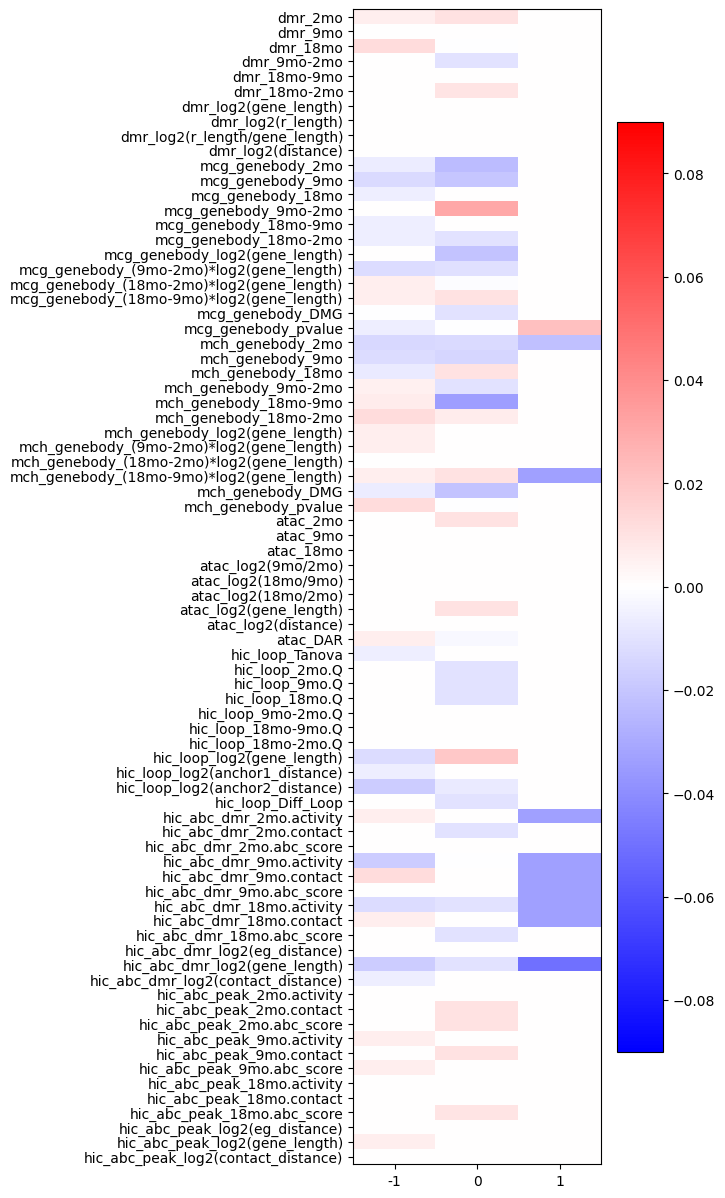

In [43]:
import matplotlib.pyplot as plt

fold_value = {}
for i in range(5):
    keys = []
    values = []
    for modality in FEATURE_MODALITIES:
        for feature_name in DATA_FEATURE_NAMES[modality]:
            keys.append(f"{modality}_{feature_name}")
            values.append(perturbed_accuracies_by_fold[i][modality][feature_name])
    fold_value[i] = np.asarray(values).squeeze() - np.asarray(
        base_accuracies_by_fold[i]
    )
min_abs_value = np.min(np.asarray([fold_value[i] for i in range(5)]))
cmap = plt.cm.bwr
norm = plt.Normalize(
    vmin=min_abs_value, vmax=-min_abs_value
)  # symmetrical range around 0
plt.figure(figsize=(4, 15))
plt.imshow(
    np.asarray([fold_value[i] for i in range(5)]).mean(axis=0),
    aspect="auto",
    cmap=cmap,
    vmin=-0.09,
    vmax=0.09,
    # norm=norm,
)
plt.yticks(range(len(keys)), keys, rotation=0)
plt.xticks([0, 1, 2], ["-1", "0", "1"])
plt.colorbar()
plt.savefig(f"{ML_OUTPUT_DIR}/{CT}_feature_perturbation.png")
plt.show()


In [44]:
import joblib

joblib.dump(
    perturbed_accuracies_by_fold, f"{ML_OUTPUT_DIR}/{CT}_perturbed_accuracies.pkl"
)
joblib.dump(base_accuracies_by_fold, f"{ML_OUTPUT_DIR}/{CT}_base_accuracies.pkl")

['ml_output/L6_IT_CTX_Glut/L6_IT_CTX_Glut_base_accuracies.pkl']